<a href="https://colab.research.google.com/github/Jeremie-Gabor97/fastai-notebooks/blob/master/Jeremie_lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab 1 | bash
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Updating fastai...
Done.
Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 31.7MB/s 


In [2]:
# check version
!pip show torch
!pip show torchvision
!pip show fastai

Name: torch
Version: 1.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: torchvision, torchtext, fastai
Name: torchvision
Version: 0.5.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: pillow, torch, six, numpy
Required-by: fastai
Name: fastai
Version: 1.0.61
Summary: fastai makes deep learning with PyTorch faster, more accurate, and easier
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numexpr, torchvision, requests, spacy, bottleneck, Pillo

## Image segmentation with CamVid

Doing something called segmentation. Create a color coded image such that objects of the class are the same color. We wont actually use color but will assign numbers to each pixel so that all pixels beloging to an object have the same number.

To create a segmentation model, you need to get a dataset where someone as labelled all the pixels in images. Very common in medicine, life sciences...
Also common for self driving cars!



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05580.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08640.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03750.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_007590_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04860_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08141_P.png')]

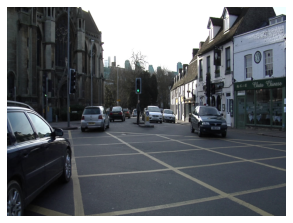

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

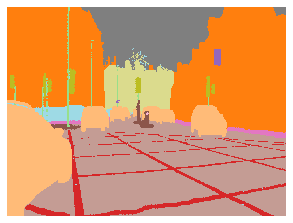

In [12]:
mask = open_mask(get_y_fn(img_f))
# not this is not an image, its a mask. So need to use open_mask
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [ 5,  5,  5,  ..., 17, 17, 17],
          [ 5,  5,  5,  ..., 17, 17, 17],
          [ 5,  5,  5,  ..., 17, 17, 17]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes
# codes.txt has a coding of what each of the colors/numbers mean

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

The dataset that we are using is frames from a video. So if we split the train and val set randomly, we could have two frames that are right next each other and thus basically the same. One in the train set and one in the val set, thats too easy. So they gave us specific names  in valid.txt to be used for val set.

In [15]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
# note we use data block api to pass our label function and codes.

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
# want if we flip x and dont flip y, then images wouldnt match up anymore, so need 

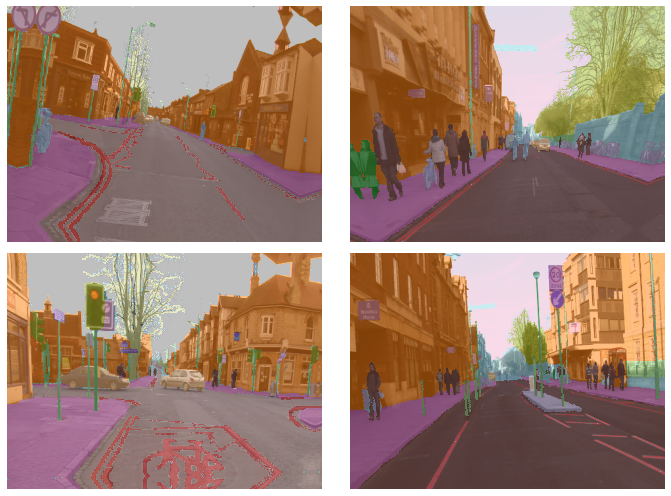

In [18]:
data.show_batch(2, figsize=(10,7))
# because it knows its a segmentation problem, it combines the pieces together
#  and will color the photo

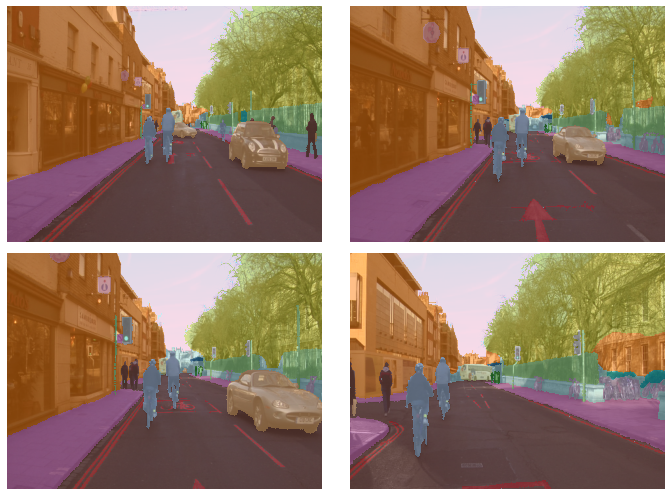

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

Concept of progressive resizing, look this up
I think the gist is to strat training classifier with smaller image size and then progressively move up.

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
# camvid has some pixels in their code images that are marked as void
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
# they recommended removing these void labelled pixels
# so we create a mask and to avoid couting the void pixels in our accuracy
# Theres often little tweaks like this in kaggle comps and what not

# Someone asked about having their trainign loss always higher than val loss
# typically due to underfitting. can be fixed by training for longer, progressively
# decresing lr or decreasing regularization.

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


For segmentation, we dont just create a conv net. We use an architecture called unet. Look this up, looks dope!!!!!!!!!!!!!!

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


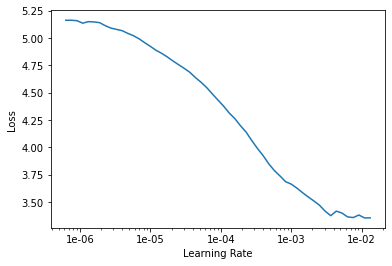

In [24]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.956680,0.769673,0.820070,01:38
1,0.751608,0.596948,0.842967,01:39
2,0.661942,0.687438,0.837002,01:39
3,0.629246,0.481319,0.865209,01:38
4,0.623230,0.524869,0.860996,01:37
5,0.608237,0.465106,0.869436,01:37
6,0.575099,0.420319,0.873721,01:36
7,0.547627,0.381693,0.890275,01:36
8,0.517763,0.462638,0.877687,01:36
9,0.418640,0.321589,0.901032,01:36


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

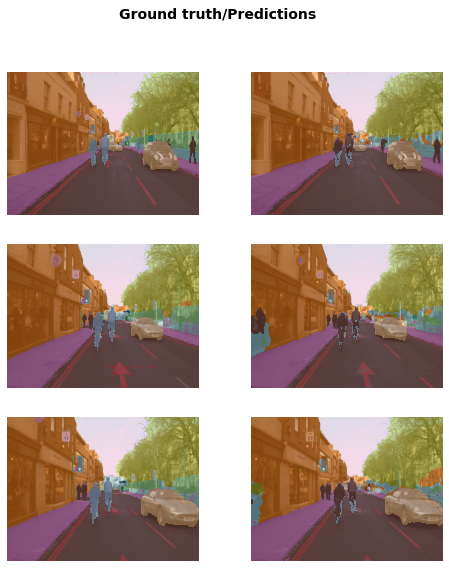

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.389799,0.313434,0.903588,01:41
1,0.369791,0.305695,0.905371,01:42
2,0.358532,0.304187,0.910032,01:42
3,0.358038,0.315384,0.905503,01:42
4,0.345297,0.297009,0.912644,01:42
5,0.330659,0.290731,0.913524,01:42
6,0.333459,0.314749,0.912199,01:42
7,0.319014,0.303403,0.912052,01:42
8,0.366569,0.339747,0.905481,01:42
9,0.430355,0.380501,0.894391,01:42


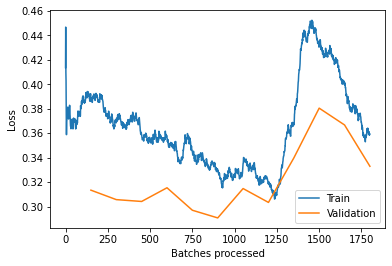

In [34]:
learn.recorder.plot_losses()
# error often goes up a bit before it goes down

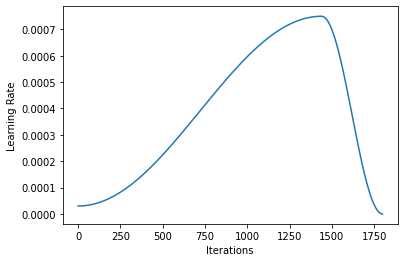

In [35]:
# the reason error goes up a bit is because lr goes up a bit and
#  then goes back down. It follows that one_cycle.
# Why is this a good idea? (Think gradient descent) You want lr to be big enough 
#  to jump over bumps but then decrease once you get close to global min. This is
#  well known and called annealing. But what is different is this increase of the lr
#  at the beginning. What was discovered was even with annealing, you might find yourself
#  in this tiny valley, your solution will probably not generalize well. But if you 
#  can find a larger flat area, then it will probably generalize better. 
#  If you have a small learning rate, youll get stuck in the valley. If you increase learning
#  rate, it will get out of the valley and then decrease again will allow it to settle.
# Doing this increase and decrease allows it to visit the whole space of solutions really well.

# You typically want to see a shape where the error rate increases a tiny bit at the beginning
#  and then decrease after that
learn.recorder.plot_lr()

In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
learn.destroy()

size = src_size
# set size to full size of image!

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


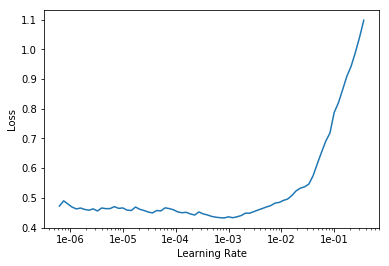

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

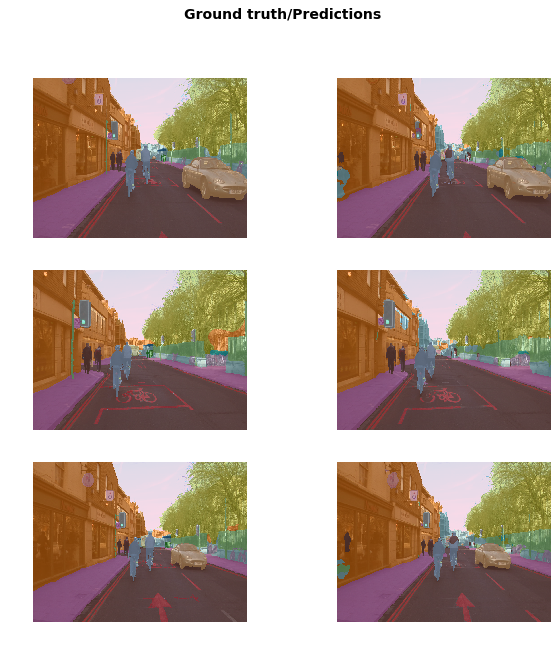

In [0]:
learn.show_results(rows=3, figsize=(10,10))

Another trick if running out of memory. Mixed precision training. Instead of using single precision floating numbers, use half precision floating numbers. If you add .to_fp16() at the end of some fastai commands then it will do it automatically. Note that it might only work on some of the most recent GPUs. 

## fin